## Active learning

<img src="./Perception_4_ActiveLearning_7_OnlineLearning.png" alt="Drawing" style="width: 800px;"/>

In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import Dataset, visualize, pickle_load, pickle_save
from augmentations import get_preprocessing, get_training_augmentation, get_validation_augmentation
import torch
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

### Load data

In [11]:
DATA_DIR = './data/CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# all data paths
X_train_paths = np.array([os.path.join(x_train_dir, image_name) for image_name in os.listdir(x_train_dir)])
y_train_paths = np.array([os.path.join(y_train_dir, image_name) for image_name in os.listdir(y_train_dir)])

X_valid_paths = np.array([os.path.join(x_valid_dir, image_name) for image_name in os.listdir(x_valid_dir)])
y_valid_paths = np.array([os.path.join(y_valid_dir, image_name) for image_name in os.listdir(y_valid_dir)])

X_test_paths = np.array([os.path.join(x_test_dir, image_name) for image_name in os.listdir(x_test_dir)])
y_test_paths = np.array([os.path.join(y_test_dir, image_name) for image_name in os.listdir(y_test_dir)])

### Create model

In [12]:
class SegModel:

    def __init__(self, arch=smp.Unet, encoder='resnet18', encoder_weights='imagenet'):
        # model params
        self.arch = arch
        self.encoder = encoder
        self.encoder_weights = encoder_weights
        self.classes = ['sky', 'building', 'pole', 'road', 'pavement', 
                        'tree', 'signsymbol', 'fence', 'car', 
                        'pedestrian', 'bicyclist']
        self.n_classes = 1 if len(self.classes) == 1 else (len(self.classes) + 1)
        self.activation = 'sigmoid' if len(self.classes) == 1 else 'softmax2d'
        self.device = 'cuda' if torch.cuda.is_available else 'cpu'
        self.model = None
        self.max_iou_score = 0
        self.preprocessing_fn = smp.encoders.get_preprocessing_fn(self.encoder, self.encoder_weights)
        # training params
        self.learning_rate = 1e-4
        self.batch_size = 8
        self.epochs = 1

    def create_epoch_runners(self, verbose=False):
        # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
        # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
        loss = smp.utils.losses.DiceLoss()
        metrics = [
            smp.utils.metrics.IoU(threshold=0.5),
        ]
        optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=self.learning_rate),
        ])
        # create epoch runners 
        # it is a simple loop of iterating over dataloader`s samples
        train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer=optimizer,
            device=self.device,
            verbose=verbose,
        )
        valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=self.device,
            verbose=verbose,
        )
        
        return train_epoch, valid_epoch
        
    def create_datasets(self, train_images_paths, train_masks_paths, valid_images_paths, valid_masks_paths):
        train_dataset = Dataset(
            train_images_paths, 
            train_masks_paths, 
            augmentation=get_training_augmentation(), 
            preprocessing=get_preprocessing(self.preprocessing_fn),
            classes=self.classes,
        )
        valid_dataset = Dataset(
            valid_images_paths,
            valid_masks_paths,
            augmentation=get_validation_augmentation(), 
            preprocessing=get_preprocessing(self.preprocessing_fn),
            classes=self.classes,
        )
        return train_dataset, valid_dataset
    
    def create_model(self):
        self.model = self.arch(encoder_name=self.encoder,
                               encoder_weights=self.encoder_weights,
                               classes=self.n_classes,
                               activation=self.activation)
        return self.model
    
    def train(self, train_images_paths, train_masks_paths, valid_images_paths, valid_masks_paths, verbose=False):
        if self.model is None: self.create_model()
        train_epoch, valid_epoch = self.create_epoch_runners(verbose=verbose)
        train_dataset, valid_dataset = self.create_datasets(train_images_paths,
                                                            train_masks_paths,
                                                            valid_images_paths,
                                                            valid_masks_paths)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=12)
        valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
        # train loop
        max_score = 0
        for i in range(0, self.epochs):
            if verbose: print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader)
            valid_logs = valid_epoch.run(valid_loader)
            # do something (save model, change lr, etc.)
            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, './best_model.pth')
                if verbose: print('Model saved!')
        # update model with the best saved
        self.max_iou_score = max_score
        self.model = torch.load('./best_model.pth')
        
    def predict(self, image_paths):
        images = []
        for image_path in image_paths:
            # input preprocessing
            image_raw = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
            image = np.copy(image_raw)
            image = cv2.resize(image, (320, 320))
            preprocessing = get_preprocessing(self.preprocessing_fn)
            image = preprocessing(image=image)['image']
            images.append(image)
        # convert to torch tensor and do inference
        x_tensor = torch.tensor(images).to(self.device)
        predictions = self.model.predict(x_tensor)
        return predictions
    
    
def model_selection_function(name):
    if name =='Unet':
        arch = smp.Unet
    elif name =='Linknet':
        arch = smp.Linknet
    elif name =='FPN':
        arch = smp.FPN
    elif name =='PSPNet':
        arch = smp.PSPNet
#     elif name =='PAN':
#         arch = smp.PAN
#     elif name =='DeepLabV3':
#         arch = smp.DeepLabV3
    else:
        print('Supported sample selection functions: Unet, Linknet, FPN, PSPNet')
        return None
    return SegModel(arch=arch)

### Active Learning experiment

- X_train, y_train: is used partially to train a model
- X_valid, y_valid: is used fully for validation
- X_test, y_test: is used as an unlabelled set to detect anomalies and add labels to train set

#### Firstly we define Anomaly detection functions here

In [13]:
def normalize(x):
    """Scale image to range 0..1 for correct entropy calculation"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
def entropy(mask_np, eps=1e-9):
    mask_np = normalize(mask_np)
    # mask_np.shape = (3, N, M)
    e = np.mean( (-mask_np * np.log2(mask_np+eps)).sum(axis=0) )
    return e
def entropy_selection(X_test_paths, n_samples, model):
    # do inference and compute entropy for each image
    entropies = []
    print('Inference on unlabelled data...')
    for img_path in tqdm(X_test_paths):
        pr_mask = model.predict([img_path])
        mask_np = pr_mask.squeeze().cpu().numpy()
        entropies.append(entropy(mask_np))
    # Model is mostly uncertain in images with High entropy
    #print('Choosing uncertain images to label...')
    selected_images_indexes = np.argsort(entropies)[::-1][:n_samples]
    print(f'Min entropy: {np.min(entropies):.2f}, \
            Mean Entropy: {np.mean(entropies):.2f}, \
            Max entropy: {np.max(entropies):.2f}')
    return selected_images_indexes

def margin(mask_np):
    mask_np = normalize(mask_np)
    rev_probas = np.sort(mask_np, axis=0)[::-1, ...]
    margins_matrix = rev_probas[0,...] - rev_probas[1,...]
    mean_margin = np.mean(margins_matrix)
    return mean_margin
def margin_selection(X_test_paths, n_samples, model):
    # do inference and compute entropy for each image
    margins = []
    print('Inference on unlabelled data...')
    for img_path in tqdm(X_test_paths):
        pr_mask = model.predict([img_path])
        mask_np = pr_mask.squeeze().cpu().numpy()
        margins.append(entropy(mask_np))
    # Model is mostly uncertain in images with Low margin
    #print('Choosing uncertain images to label...')
    selected_images_indexes = np.argsort(margins)[:n_samples]
    print(f'Min margin: {np.min(margins):.2f}, \
            Mean margin: {np.mean(margins):.2f}, \
            Max margin: {np.max(margins):.2f}')
    return selected_images_indexes

def random_samples_selection(X, n_samples, model=None):
    selected_images_indexes = np.random.choice(len(X), n_samples, replace=False)
    return selected_images_indexes

def sample_selection_function(name):
    if name=='Random': return random_samples_selection
    elif name=='Entropy': return entropy_selection
    elif name=='Margin': return margin_selection
    else: print('Supported sample selection functions: Random, Entropy, Margin')

#### Main AL experiment

In [14]:
def al_experiment(model_str, samples_selection_fn, k, visualize_most_uncertain=False, verbose_train=False):
    # define model from its name
    model = model_selection_function(model_str)
    model.epochs = MODEL_TRAIN_EPOCHS
    # define samples selection function from its name
    samples_selection_fn = sample_selection_function(samples_selection_str)
    
    IoUs = [0.]
    N_train_samples = [0]

    # select k random samples from initial dataset and treat it as initially labelled data
    X = np.copy(X_train_paths)
    y = np.copy(y_train_paths)
    selection = np.random.choice(len(X), INITIAL_N_TRAIN_IMAGES, replace=False) # k
    X_train_paths_part = X[selection]
    y_train_paths_part = y[selection]

    X_test = np.copy(X_test_paths)
    y_test = np.copy(y_test_paths)

    # main loop
    while len(X_train_paths_part) <= MAX_QUEERY_IMAGES:
        # train model
        print('Labelled set size: ', len(X_train_paths_part))
        print('Unlabelled set size: ', len(X_test))
        print(f'\nTraining a model for {MODEL_TRAIN_EPOCHS} epochs...')
        model.train(X_train_paths_part, y_train_paths_part, X_valid_paths, y_valid_paths, verbose=verbose_train)

        # remeber results
        print(f'IoU so far: {model.max_iou_score}')
        IoUs.append(model.max_iou_score)
        N_train_samples.append(len(X_train_paths_part))
        
        if len(X_test) < k:
            print('\nNo more images in Unlabelled set')
            break
            
        selected_images_indexes = samples_selection_fn(X_test, k, model)

        # Add labels for uncertain images to train data
        #print('Labelled set before: ', len(X_train_paths_part))
        X_train_paths_part = np.concatenate([X_train_paths_part, X_test_paths[selected_images_indexes]])
        y_train_paths_part = np.concatenate([y_train_paths_part, y_test_paths[selected_images_indexes]])
        #print('Labelled set after: ', len(X_train_paths_part))

        # Visualization
        if visualize_most_uncertain:
            print('Visualizing most uncertain results so far:')
            for i in selected_images_indexes[:1]:
                img_path = X_test[i]
                image = cv2.imread(img_path)[...,(2,1,0)]
                gt_mask = cv2.imread(y_test_paths[i])
                pr_mask = model.predict([img_path])
                mask_np = pr_mask.squeeze().cpu().numpy().round()

                visualize(image=image, car_mask=mask_np[0,...], road_mask=mask_np[1,...])

        # Remove labelled data from validation set
        #print('Unlabelled set before: ', len(X_test))
        X_test = np.delete(X_test, selected_images_indexes)
        y_test = np.delete(y_test, selected_images_indexes)
        #print('Unlabelled set after: ', len(X_test))
        
    print(f'Max IoU score: {np.max(IoUs)}')
    print('----------------------------------------\n')
    return IoUs, N_train_samples

In [15]:
MAX_QUEERY_IMAGES = 360 # 220 # maximum number of images to train on during AL loop
MODEL_TRAIN_EPOCHS = 5 # 5 # number of epochs to train a model during one AL cicle
INITIAL_N_TRAIN_IMAGES = 80 # 20, initial number of accessible labelled images
NUM_UNCERTAIN_IMAGES = [10]#, 20, 40, 60] # k: number of uncertain images to label at each AL cicle
SAMPLES_SELECTIONS = ['Margin', 'Random', 'Entropy']
MODELS = ['Unet']#, 'Linknet', 'FPN', 'PSPNet']

In [16]:
name = ''
for model in MODELS:
    name += model + '_'
#name += 'Nsamples_'+str(MAX_QUEERY_IMAGES)
name += 'epochs_'+str(MODEL_TRAIN_EPOCHS)
name += '_N0_'+str(INITIAL_N_TRAIN_IMAGES)
name += '_Ks_'
for k in NUM_UNCERTAIN_IMAGES:
    name += str(k) + '_'
for fn in SAMPLES_SELECTIONS:
    name += fn + '_'
RESULTS_FNAME = name+'.pkl'
print(RESULTS_FNAME)

Unet_epochs_5_N0_80_Ks_10_Margin_Random_Entropy_.pkl


In [8]:
results = {}

# choose model
for model_str in MODELS:
    print(f'\nModel name: {model_str}')
    print('------------------------------------')
    results[model_str] = {}
    
    # choose samples selection function
    for samples_selection_str in SAMPLES_SELECTIONS:
        print(f'\nSamples selection function: {samples_selection_str}')
        print('------------------------------------')
        results[model_str][samples_selection_str] = {}
        
        # choose number of samples to select for labelling from inference results
        for k in NUM_UNCERTAIN_IMAGES:
            print(f'\nNumber of samples to label on one iteration, k={k}')
            print('------------------------------------')
            results[model_str][samples_selection_str][str(k)] = {}
            
            IoUs, N_train_samples = al_experiment(model_str, samples_selection_str, k, verbose_train=False)
            
            results[model_str][samples_selection_str][str(k)]['IoUs'] = IoUs
            results[model_str][samples_selection_str][str(k)]['N_train_samples'] = N_train_samples
            
pickle_save(RESULTS_FNAME, results)


Model name: Unet
------------------------------------

Samples selection function: Margin
------------------------------------

Number of samples to label on one iteration, k=10
------------------------------------
Labelled set size:  60
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:13, 17.14it/s]

IoU so far: 0.008339783786519403
Inference on unlabelled data...


100%|██████████| 233/233 [00:13<00:00, 16.66it/s]

Min margin: 2.82,             Mean margin: 4.16,             Max margin: 5.19
Labelled set size:  70
Unlabelled set size:  223

Training a model for 1 epochs...



  1%|          | 2/223 [00:00<00:13, 16.93it/s]

IoU so far: 0.09982560409030104
Inference on unlabelled data...


100%|██████████| 223/223 [00:13<00:00, 16.43it/s]

Min margin: 2.47,             Mean margin: 3.68,             Max margin: 5.29
Labelled set size:  80
Unlabelled set size:  213

Training a model for 1 epochs...



  1%|          | 2/213 [00:00<00:12, 16.51it/s]

IoU so far: 0.2047110791548644
Inference on unlabelled data...


100%|██████████| 213/213 [00:12<00:00, 16.89it/s]

Min margin: 2.54,             Mean margin: 3.69,             Max margin: 4.96
Labelled set size:  90
Unlabelled set size:  203

Training a model for 1 epochs...



  1%|          | 2/203 [00:00<00:11, 17.63it/s]

IoU so far: 0.2296323358717531
Inference on unlabelled data...


100%|██████████| 203/203 [00:11<00:00, 17.20it/s]

Min margin: 2.73,             Mean margin: 3.34,             Max margin: 4.32
Labelled set size:  100
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:11, 16.97it/s]

IoU so far: 0.250287974382391
Inference on unlabelled data...


100%|██████████| 193/193 [00:10<00:00, 17.65it/s]

Min margin: 2.81,             Mean margin: 3.51,             Max margin: 4.66
Labelled set size:  110
Unlabelled set size:  183

Training a model for 1 epochs...



  1%|          | 2/183 [00:00<00:10, 17.18it/s]

IoU so far: 0.41769500593147657
Inference on unlabelled data...


100%|██████████| 183/183 [00:10<00:00, 17.20it/s]

Min margin: 2.71,             Mean margin: 3.35,             Max margin: 4.65
Labelled set size:  120
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:09, 17.93it/s]

IoU so far: 0.5107538632237084
Inference on unlabelled data...


100%|██████████| 173/173 [00:09<00:00, 17.52it/s]


Min margin: 2.35,             Mean margin: 2.97,             Max margin: 4.02
Max IoU score: 0.5107538632237084
----------------------------------------


Samples selection function: Random
------------------------------------

Number of samples to label on one iteration, k=10
------------------------------------
Labelled set size:  60
Unlabelled set size:  233

Training a model for 1 epochs...
IoU so far: 0.009595135716279955
Labelled set size:  70
Unlabelled set size:  223

Training a model for 1 epochs...
IoU so far: 0.10901044080458061
Labelled set size:  80
Unlabelled set size:  213

Training a model for 1 epochs...
IoU so far: 0.16747095878466522
Labelled set size:  90
Unlabelled set size:  203

Training a model for 1 epochs...
IoU so far: 0.22805819416990375
Labelled set size:  100
Unlabelled set size:  193

Training a model for 1 epochs...
IoU so far: 0.22364519285683593
Labelled set size:  110
Unlabelled set size:  183

Training a model for 1 epochs...
IoU so far: 0.3059675898

  1%|          | 2/233 [00:00<00:16, 14.01it/s]

IoU so far: 0.07881362098130848
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 14.77it/s]

Min entropy: 4.80,             Mean Entropy: 5.47,             Max entropy: 5.62
Labelled set size:  70
Unlabelled set size:  223

Training a model for 1 epochs...



  1%|          | 2/223 [00:00<00:13, 16.63it/s]

IoU so far: 0.23895486082771028
Inference on unlabelled data...


100%|██████████| 223/223 [00:14<00:00, 15.82it/s]

Min entropy: 2.48,             Mean Entropy: 3.55,             Max entropy: 4.79
Labelled set size:  80
Unlabelled set size:  213

Training a model for 1 epochs...



  1%|          | 2/213 [00:00<00:12, 17.04it/s]

IoU so far: 0.35976445674896246
Inference on unlabelled data...


100%|██████████| 213/213 [00:12<00:00, 17.43it/s]

Min entropy: 1.73,             Mean Entropy: 2.44,             Max entropy: 3.44
Labelled set size:  90
Unlabelled set size:  203

Training a model for 1 epochs...



  1%|          | 2/203 [00:00<00:12, 16.13it/s]

IoU so far: 0.32345420918842355
Inference on unlabelled data...


100%|██████████| 203/203 [00:11<00:00, 17.00it/s]

Min entropy: 1.83,             Mean Entropy: 2.66,             Max entropy: 3.54
Labelled set size:  100
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:11, 16.80it/s]

IoU so far: 0.4028953706273937
Inference on unlabelled data...


100%|██████████| 193/193 [00:11<00:00, 17.31it/s]

Min entropy: 1.93,             Mean Entropy: 2.40,             Max entropy: 2.78
Labelled set size:  110
Unlabelled set size:  183

Training a model for 1 epochs...



  1%|          | 2/183 [00:00<00:10, 16.93it/s]

IoU so far: 0.4047617047730061
Inference on unlabelled data...


100%|██████████| 183/183 [00:10<00:00, 17.02it/s]

Min entropy: 1.62,             Mean Entropy: 2.37,             Max entropy: 2.81
Labelled set size:  120
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:10, 16.71it/s]

IoU so far: 0.4273579250467885
Inference on unlabelled data...


100%|██████████| 173/173 [00:10<00:00, 17.28it/s]

Min entropy: 1.99,             Mean Entropy: 2.44,             Max entropy: 2.84
Max IoU score: 0.4273579250467885
----------------------------------------

saved Unet_epochs_1_N0_60_Ks_10_Margin_Random_Entropy_.pkl /home/ruslan/Desktop/DoEdu/src/active_learning/src ['data', 'Unet_epochs_2_N0_80_Ks_10_20_Margin_Random_Entropy_.pkl', 'test.pkl', 'Unet_epochs_5_N0_80_Ks_10_Margin_Random_Entropy_.pkl', 'Unet_epochs_1_N0_60_Ks_10_Margin_Random_Entropy_.pkl', 'augmentations.py', 'utils.py', 'unet_best_model.pth', 'many_models_entropy_results.pkl', '__pycache__', 'best_model.pth', 'active_learning_semantic_segmentation.ipynb', 'Active_Learning_Tutorial.ipynb', 'Perception_4_ActiveLearning_7_OnlineLearning.png', '.ipynb_checkpoints', '.gitignore', 'train_semantic_segmentation.ipynb']


## Results

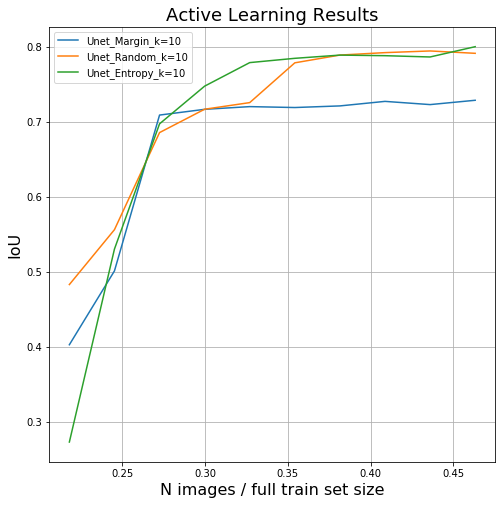

In [17]:
results = pickle_load(RESULTS_FNAME)

plt.figure(figsize=(8,8))

# choose model
for model_str in MODELS:    
    # choose samples selection function
    for samples_selection_str in SAMPLES_SELECTIONS:        
        # choose number of samples to select for labelling from inference results
        for k in NUM_UNCERTAIN_IMAGES:

            ious = results[model_str][samples_selection_str][str(k)]['IoUs']
            n_train = results[model_str][samples_selection_str][str(k)]['N_train_samples']

            plt.plot(np.array(n_train[1:][:10])/len(X_train_paths), ious[1:][:10], label=model_str+'_'+samples_selection_str+'_k='+str(k))
        
plt.grid()
plt.title('Active Learning Results', fontsize=18)
plt.xlabel('N images / full train set size', fontsize=16)
plt.ylabel('IoU', fontsize=16)
plt.legend();